# Basics of XGA profiles - focusing on cluster surface brightness

Here the aim is to go through the basic capabilities of XGA profile products, with a focus on the generation of surface brightness profiles of galaxy clusters. A demonstration of the fitting functionality built into XGA profiles will be given, which will include an exploration of the XGA model classes and their purpose. I'll also show how we can view profiles (both for individually and together), and run through the user-configurable options built into the view method. 

Given the nature of this analysis, it isn't really applicable to point-like sources.

In [1]:
from xga.sources import GalaxyCluster

from astropy.units import Quantity
import numpy as np

Firstly, I will define a GalaxyCluster source for Abell 907, a cluster for which I know high quality data is available. **Again, please note that the overdensity radius and redshift that I've used here are approximate and should not be used for a scientific analysis**:

In [2]:
src = GalaxyCluster(149.59209, -11.05972, 0.16, r500=Quantity(1200, 'kpc'), name='A907')
src.info()


-----------------------------------------------------
Source Name - A907
User Coordinates - (149.59209, -11.05972) degrees
X-ray Peak - (149.59251340970866, -11.063958320861634) degrees
nH - 0.0534 1e+22 / cm2
Redshift - 0.16
XMM ObsIDs - 3
PN Observations - 3
MOS1 Observations - 3
MOS2 Observations - 3
On-Axis - 3
With regions - 3
Total regions - 69
Obs with one match - 3
Obs with >1 matches - 0
Images associated - 18
Exposure maps associated - 18
Combined Ratemaps associated - 1
Spectra associated - 0
R500 - 1200.0 kpc
R500 SNR - 251.61
-----------------------------------------------------



## Generating and viewing a surface brightness profile

A [convenient method](../../xga.sources.html#xga.sources.extended.GalaxyCluster.view_brightness_profile) for quickly generating and viewing cluster surface brightness profiles has been implemented in the GalaxyCluster source class, with the main input being the desired outer radius of the brightness profile in question. In this demonstration I have made a profile out to the approximate R$_{500}$ that I supplied on declaration, and by default this method has used the combined brightness profile to do so:

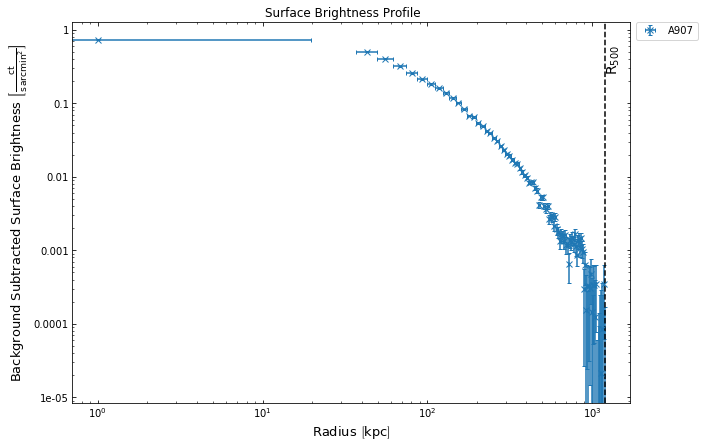

In [3]:
src.view_brightness_profile('r500')

The `view_brightness_profile` method doesn't actually create the brightness profile itself however, it is simply a wrapper around the [radial_brightness](../../xga.imagetools.html#xga.imagetools.profile.radial_brightness) function implemented in the 'imagetools' section of XGA. I will not go into detail on how the generation is undertaken, but the end result is an instance of the XGA [SurfaceBrightness1D](../../xga.products.html#xga.products.profile.SurfaceBrightness1D) class. I will mention, however, that you can supply minimum quality requirements when generating these profiles, for instance requiring each bin to have a minimum signal to noise, as shown here:

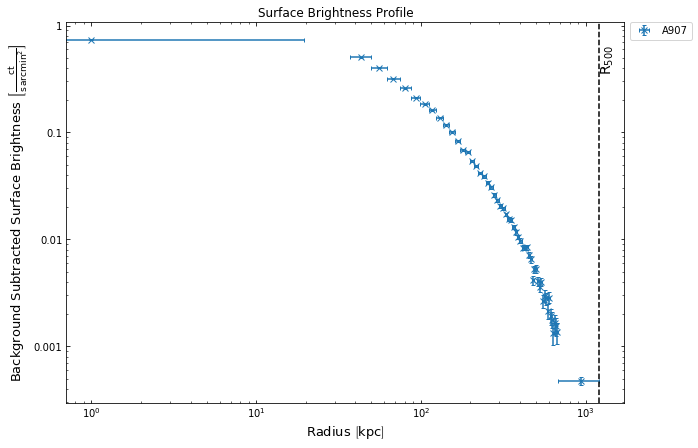

In [4]:
src.view_brightness_profile('r500', min_snr=1.1)

## Retrieving the SurfaceBrightness1D instance from the source

It is likely that you want to do more than just look at the profile, so the next step is to extract it from wherever it has been stored in the source object. Most profile types have a specific get method, but a general `get_profiles` method also exists, which I shall show first. We have to supply the profile type, with a 'combined_' prefix to indicate that the profile was generated using combined data:

In [5]:
src.get_profiles('combined_brightness')

We can see that because we only supplied the type of profile we want, both the brightness profiles we generated have been returned to us. If we specifically wanted the profile we generated out to $R_{500}$ without any automatic re-binning however, we can use the `get_1d_brightness_profile` method and tell it that the outer radius of the profile we want is R$_{500}$ (something that, after the re-binning applied to the second profile, is no longer true for both):

In [6]:
sb_prof = src.get_1d_brightness_profile('r500')
sb_prof

## Saving XGA profiles to disk

All profiles generated by XGA are automatically saved to the {xga save path}/profiles/{source name} directory, so that if the same source is declared again at some point in the future then they can be loaded back in without having to run the generation again. Running the generation procedure again for brightness profiles wouldn't be much of a problem, considering how fast it is, but other profiles take considerably more time to generate.

A profile will generally automatically re-save itself when a change (such as fitting a model) is made to it, and you can manually save it by calling the `save()` method and passing a path. 

The profile is saved by pickling the profile instance, which can result in some relatively large files if there are many points and model fits stored within the profile:

In [7]:
sb_prof.save("random_brightness_profile.xga")

If you have a profile object loaded in then you can access the automatic save path which XGA has assigned it by using the `save_path` property:

In [8]:
sb_prof.save_path

'/home/dt237/code/PycharmProjects/XGA/docs/source/notebooks/advanced_tutorials/xga_output/profiles/A907/brightness_profile_A907_40420746.xga'

## Fitting a model to the SurfaceBrightness1D instance

So, we've generated this profile, and now we've decided we want to be able to represent it with a model. You, as a new user, don't know a priori what models have been implemented for whatever profile type you're working with; as such you should call the `allowed_models()` method, which will tell you what models you're allowed to fit: 

In [9]:
# Passing grid here changes the style of the table. The default style looks nicer in my opinion, but LaTeX
#  has a hard time rendering it for the PDF version of this documentation
sb_prof.allowed_models('grid')

+--------------+---------------------------------------------+-----------------------------------------+
| MODEL NAME   | EXPECTED PARAMETERS                         | DEFAULT START VALUES                    |
+==============+=============================================+=========================================+
| beta         | beta, r_core, norm                          | 1.0, 100.0 kpc, 1.0 ct / (arcmin2 s)    |
+--------------+---------------------------------------------+-----------------------------------------+
| double_beta  | beta_one, r_core_one, norm_one, beta_two,   | 1.0, 100.0 kpc, 1.0 ct / (arcmin2 s),   |
|              | r_core_two, norm_two                        | 0.5, 400.0 kpc, 0.5 ct / (arcmin2 s)    |
+--------------+---------------------------------------------+-----------------------------------------+


Now that you can see which models you're allowed to fit to this particular type of profile, we might decide that we're going to fit the simple beta model. There are a couple of slightly different ways we could decide to do this, with the simplest being we just pass the name of the model as a string to the `fit` method of the profile. This would declare an instance of that model class, with the default starting values and priors, and then fit it.

Alternatively, we could decide that we want to customise the model parameters, declare an instance of that particular model manually, and pass it to the fitting function. I'm going to demonstrate this approach, so I can introduce you to the way models work in XGA; firstly, we have to import the model that we chose:

In [10]:
# I do not condone importing anywhere but the top of a Jupyter notebook, but it 
#  helps the demonstration to do it here
from xga.models import BetaProfile1D

When we called the `allowed_models` method we were shown the default start values for the model parameters, including the required units, and so we can declare suitable astropy quantities now as we declare a new model instance with non-standard start values (the model will error if start parameters with the wrong units are passed):

In [11]:
beta_inst = BetaProfile1D(cust_start_pars=[Quantity(0.8), Quantity(50, 'kpc'), Quantity(0.6, 'ct/(arcmin^2 s)')])
beta_inst.start_pars

[<Quantity 0.8>, <Quantity 50. kpc>, <Quantity 0.6 ct / (arcmin2 s)>]

I am not claiming that these are 'better' start values than the default ones for this particular cluster, I am simply doing this for demonstrative purposes. Model classes have many built in methods, some of which provide visualisations of the model, some provide convenient access to derivatives and integrated values, and some just provide general information about the model:

In [12]:
beta_inst.info('grid')

+-----------------+-----------------------------------------------------------------------------+
| Beta Profile    |                                                                             |
+=================+=============================================================================+
| DESCRIBES       | Surface Brightness                                                          |
+-----------------+-----------------------------------------------------------------------------+
| UNIT            | ct / (arcmin2 s)                                                            |
+-----------------+-----------------------------------------------------------------------------+
| PARAMETERS      | beta, r_core, norm                                                          |
+-----------------+-----------------------------------------------------------------------------+
| PARAMETER UNITS | , kpc, ct / (arcmin2 s)                                                     |
+-----------------+-

Now that we've setup our model instance, we're going to fit it to the profile. There are several fitting methods implemented in the profile base class, including one based on the `emcee` ensemble MCMC sampler, one based around `scipy`'s 'curve_fit' implementation of non-linear least squares, and one based around `scipy`'s implementation of orthogonal distance regression. We shall use the MCMC fitter here, with a simple gaussian likelihood, as I wish to demonstrate some of the extra features that are enabled with an MCMC fit. **I will mention again that you could just pass 'beta' as the first argument here if you just wished to use the default beta model setup**:

In [13]:
sb_prof.fit(beta_inst, num_steps=30000, num_walkers=20)

100%|██████████| 30000/30000 [00:31<00:00, 954.02it/s]


The fit method will return a model instance (in this case the same one we passed in), which has had the fit results added to it, though you can also retrieve the fit directly from the profile object (as the model is stored internally). We have to specify the name of the model as well as the fit type, as the same type of model can be fitted and stored with multiple fit methods:

In [14]:
sb_prof.get_model_fit('beta', 'mcmc')

## Exploring the fitted model

Due to the fact that we setup our own model instance prior to running the fit method (and the way Python memory addressing works), we can actually just look at our initial `beta_inst` model, we don't need to retrieve it from the object or the fit method (notice we never assigned their return to a variable). The model class has three visualisation methods implemented, though they are meant more for convenience than for the production of publishable figures. We can view the model curve (if we pass radii at which we wish to calculate values), and the parameter distributions from the fit:

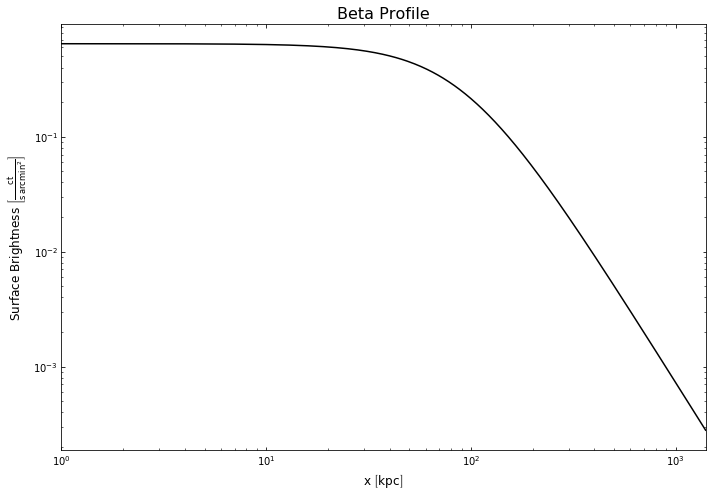

In [15]:
# We have to pass radii at which to evaluate the model, I just pass a set of radii 
#  from 1 (because its a log scale by default) to 1400kpc.
beta_inst.view(Quantity(np.arange(1, 1400, 1), 'kpc'), figsize=(10,7))

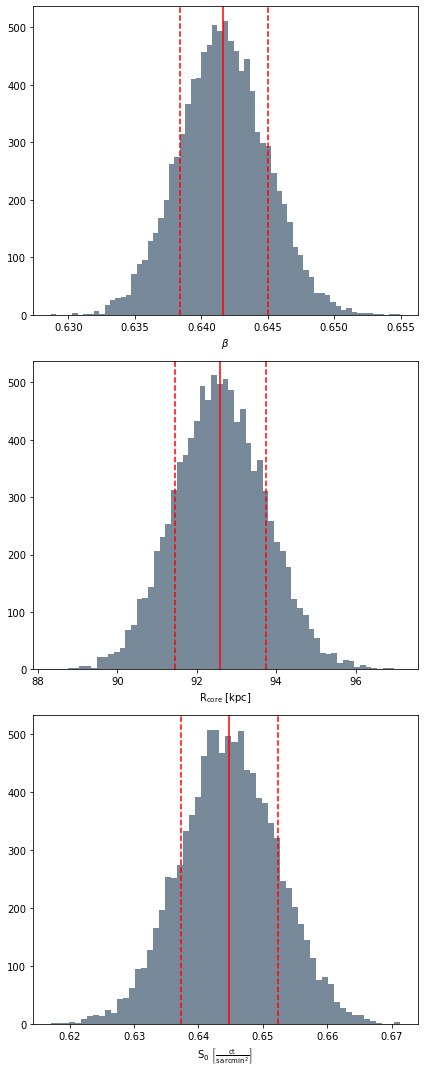

In [16]:
beta_inst.par_dist_view()

## Mathematics with the fitted model

There are various ways of interacting with the model mathematically, the simplest of which is using the fitted model to predict a value at a particular radius. For this you just need to call the model instance and pass the radius at which you wish to evaluate the model, no further information is required as the knowledge of the model parameter values is stored within the instance:

In [17]:
beta_inst(Quantity(600, 'kpc'))

<Quantity [0.00303417] ct / (arcmin2 s)>

By default this returns a single value, using the best fit values to predict it; however more often than not a single value is not very useful, we need knowledge of the uncertainty associated with it. In this case we can use the parameter posterior distributions to calculate a value distribution at the given radius:

In [18]:
beta_inst(Quantity(600, 'kpc'), use_par_dist=True)

<Quantity [0.00296653, 0.00305163, 0.00295236, ..., 0.00298944, 0.00305095,
           0.0029806 ] ct / (arcmin2 s)>

On a slight side note, you can also have a quick look at the predicted distribution in histogram form:

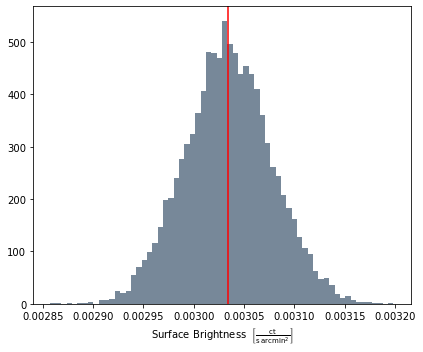

In [19]:
beta_inst.predicted_dist_view(Quantity(600, 'kpc'))

If you have a model instance and wanted to make a prediction using parameter values other than those from the fitting process, you can use the model method and manually pass parameters:

In [21]:
beta_inst.model(Quantity(600, 'kpc'), Quantity(2, ''), Quantity(240, 'kpc'), Quantity(2, 'ct/(arcmin^2s)'))

<Quantity 3.70826669e-05 ct / (arcmin2 s)>

There are also convenient ways to calculate derivatives of the model, and again we can either return a single value or a distribution (again by setting the `use_par_dist` argument). In general, if there is an analytical solution to the 1st derivative of a model that has been implemented in XGA, then the analytical solution is what is being used to calculate the value. If there is no analytical solution then the scipy `derivative` function is being used, and the user must pass an appropriate `dx` value - this function is also what is used to calculate nth order derivatives:

In [23]:
beta_inst.derivative(Quantity(600, 'kpc'))

<Quantity [-1.40762347e-05] ct / (arcmin2 kpc s)>

In [25]:
beta_inst.nth_derivative(Quantity(600, 'kpc'), dx=Quantity(0.01, 'kpc'), order=2, use_par_dist=True)

<Quantity [8.68820207e-08, 8.83093598e-08, 8.73639442e-08, ...,
           8.68004453e-08, 8.83717665e-08, 8.76585870e-08] ct / (arcmin2 kpc2 s)>

Other mathematical functions include `inverse_abel` for performing inverse abel transforms on the models, and `volume_integral`, for performing volume integrals using the model. You can read more about them in the [BaseModel1D API documentation](../../xga.models.html#xga.models.base.BaseModel1D).

## Back to the profile